In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from astropy.io import fits

In [3]:
figsize(8,6)

In [4]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p, hits, ra_bins, dec_bins

In [5]:
# cut off A below 160, same with B 
# cut C and D above 360
# or just keep only 200-400

In [6]:
def get_data(bank='A', session=5):
    fnames = glob.glob('/data2/GBT/S140/Daisy/*/*_0'+str(session)+'_*'+bank+'*.rfireduced_new.npz')
    fnames.sort()
    calibrations = np.load('/home/mabitbol/GBT-S140/calibrations/calibrationyy_3C295_0'+str(session)+'_'+bank+'.npy').item()
    fdiode = calibrations['freqs']
    pdiode = calibrations['pdiode']
    #pdiode1 = calibrations['pdiode1']
    #meanpower = 0.5 * (pdiode + pdiode1)
    calibrated = [] 
    ras = []
    decs = []
    meansub = []
    azs = []
    els = []
    gain0 = []
    gain1 = []
    for fname in fnames:
        nz = np.load(fname)
        ra = nz['sra']
        dec = nz['sdec']
        mask = nz['valid']
        az = nz['AZIMUTH'][::8]
        el = nz['ELEVATIO'][::8]
        freqs = nz['freqs']
            
        gain = pdiode / ( nz['yyon'] - nz['yyoff'])
        calibd = nz['yyoff'] * gain
        
        mask[:200] = False
        mask[400:] = False
    
        calibd = calibd[:, mask]

        calibrated = np.concatenate([calibrated, np.nanmean(calibd - np.nanmedian(calibd,0), 1)])
        meansub = np.concatenate([meansub, np.nanmean(calibd,1) - np.nanmedian(np.nanmean(calibd,1))])
        ras = np.concatenate([ras, ra])
        decs = np.concatenate([decs, dec])
        azs = np.concatenate([azs, az])
        els = np.concatenate([els, el])

        gain0 = np.concatenate([gain0, np.nanmean(gain[:, mask], 0)])
        gain1 = np.concatenate([gain1, np.nanmean(gain[:, mask], 1)])
    return calibrated, meansub, ras, decs, azs, els, gain0, gain1

In [7]:
# bank A
# for session 3 cut off 35000 to 50000
# for session 3 cut off 1625000 to end
# bank B
# for session 3 cut off 62000 to 72000
# for session 3 cut off 120000 to 128000
# bank C and D
# for session 3 cut off 38000 to 39000

In [8]:
def get_maps(bank='A', session=5, doplot=True, dosave=True):
    calibrated, meansub, ras, decs, azs, els, gain0, gain1 = get_data(bank, session)
    
    tmask = np.ones(len(calibrated), dtype=bool)
    ts = np.arange(len(calibrated))
    if session == 5:
        tmask = (ts < 42000) | (ts > 50000 )
    if session == 3:
        if bank == 'A':
            tmask[(ts > 30000) * (ts < 60000 )] = False
            tmask[(ts > 162500)] = False
        if bank == 'B':
            tmask[(ts > 62000) * (ts < 72000 )] = False
            tmask[(ts > 120000) * (ts < 128000 )] = False
        else:
            tmask[(ts > 38000) * (ts < 39000 )] = False
        
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    rapix = int((ras.max() - ras.min()) / (beam / 60.))
    decpix = int((decs.max() - decs.min()) / (beam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated[tmask], ras[tmask], decs[tmask], rapix, decpix)
    mask = hits == 0
    signal = datamap / hits
    signal[mask] = np.nan
    
    varmap = np.nanstd(calibrated[tmask])/np.sqrt(hits)
    mask = hits == 0
    varmap[mask] = np.nan
    
    if doplot:
        figure()
        plot(calibrated[tmask])
        ylim(-1, 1)

        figure()
        pc = pcolormesh(rabins, decbins, signal.T)
        clim(-0.1, 0.1)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy]')

        figure()
        pc = pcolormesh(rabins, decbins, hits.T)
        clim(1, 40)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Hits')

        figure()
        pc = pcolormesh(rabins, decbins, varmap.T)
        clim(0, 0.02)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Sqrt Variance [Jy]')
    
    if dosave:
        z = {'rabins': rabins, 'decbins':decbins, 'signal':signal.T, 'hits':hits.T, 'weight':varmap.T, 
            'calibrated':calibrated, 'meansub':meansub, 'ras':ras, 'decs':decs, 'azs':azs, 'els':els, 
            'gain0':gain0, 'gain1':gain1, 'tmask':tmask}
        np.savez('/home/mabitbol/GBT-S140/datamaps/datamapsyy_'+bank+'_'+str(session), **z)
    return calibrated, gain0, gain1

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


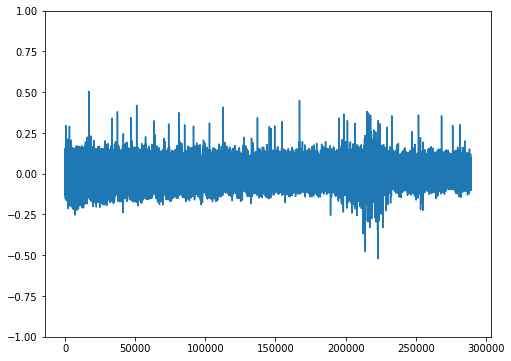

/usr/lib64/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


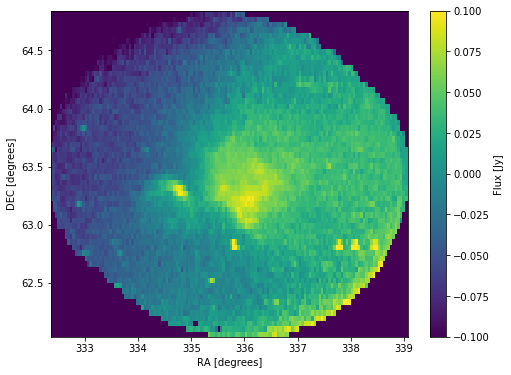

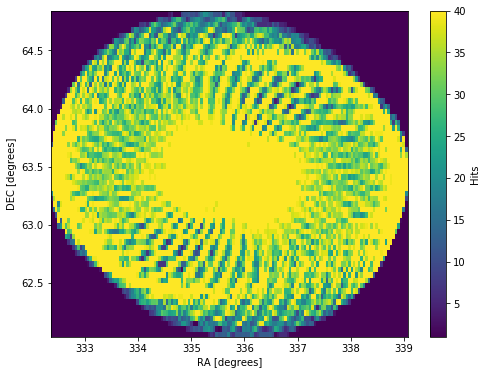

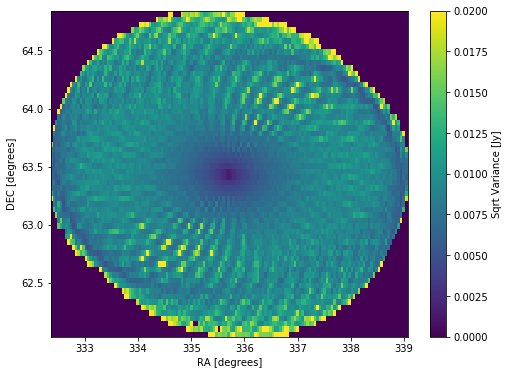

In [9]:
calibrated, gain0, gain1 = get_maps('A', 5)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


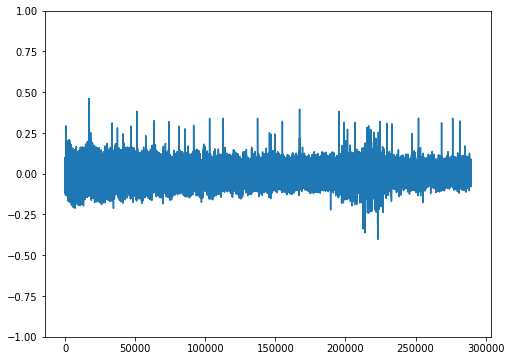

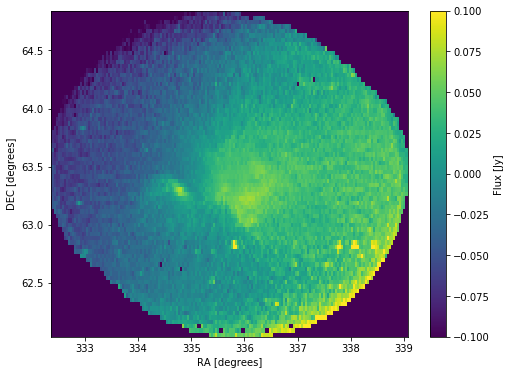

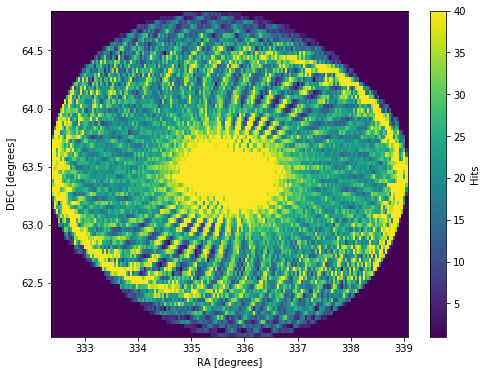

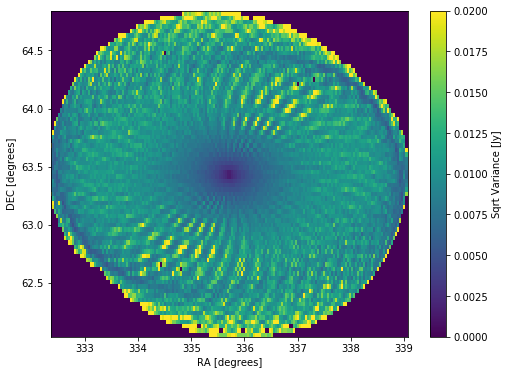

In [10]:
calibrated, gain0, gain1 = get_maps('B', 5)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


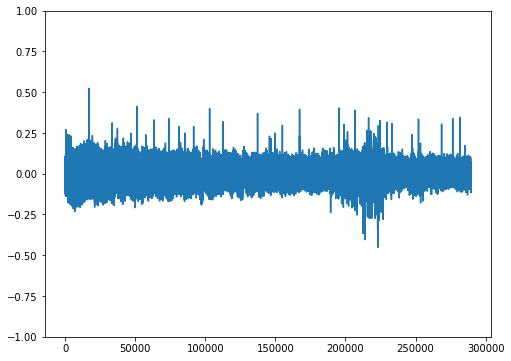

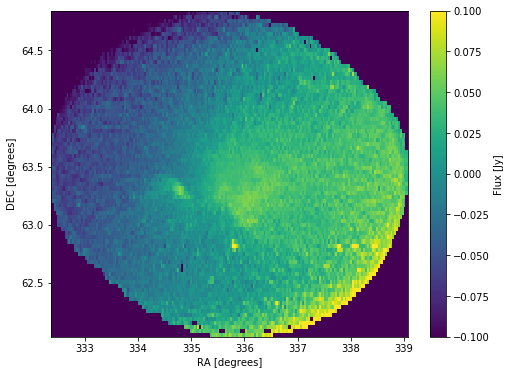

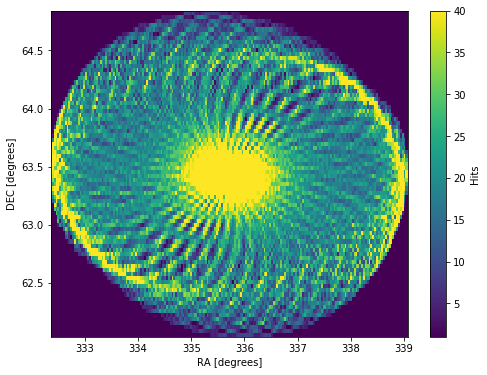

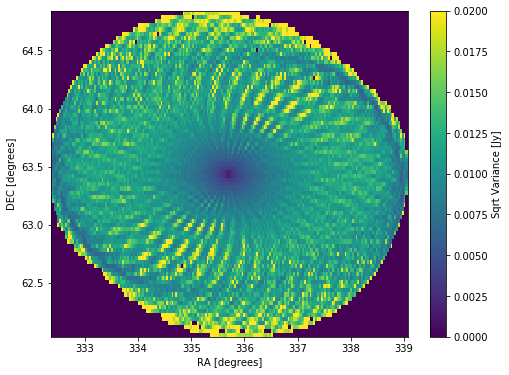

In [11]:
calibrated, gain0, gain1 = get_maps('C', 5)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


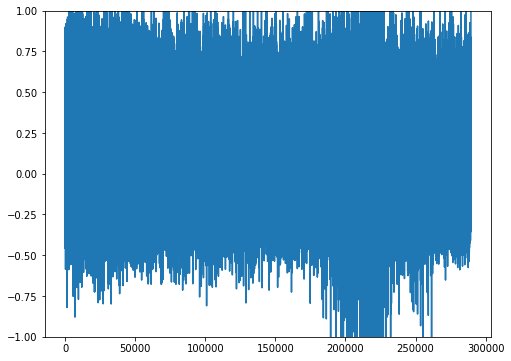

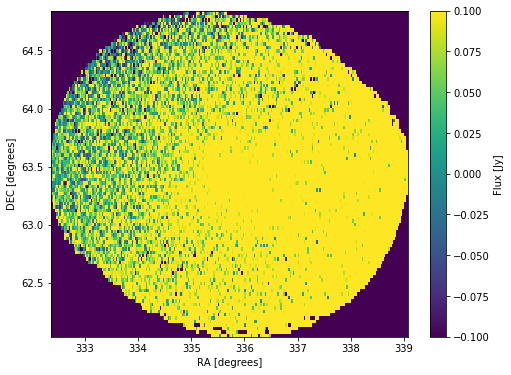

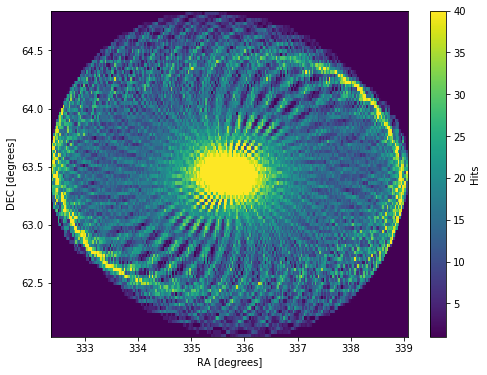

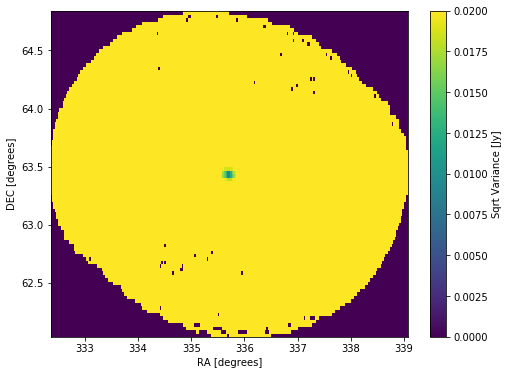

In [12]:
calibrated, gain0, gain1 = get_maps('D', 5)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


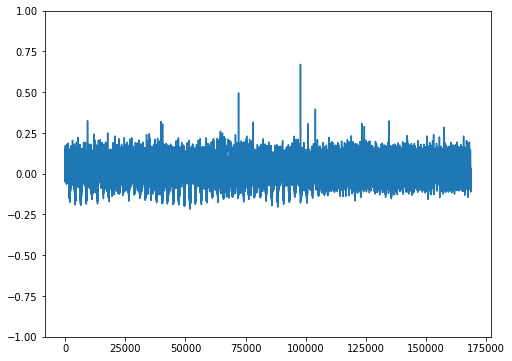

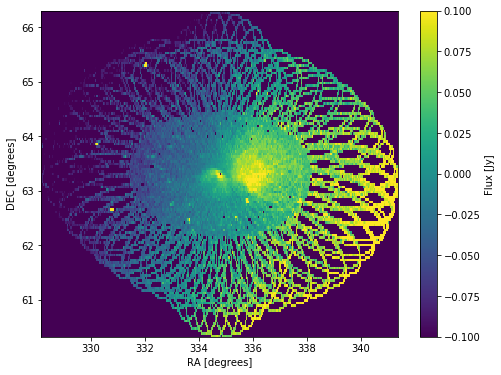

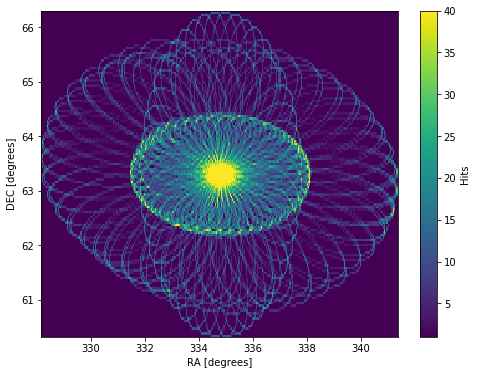

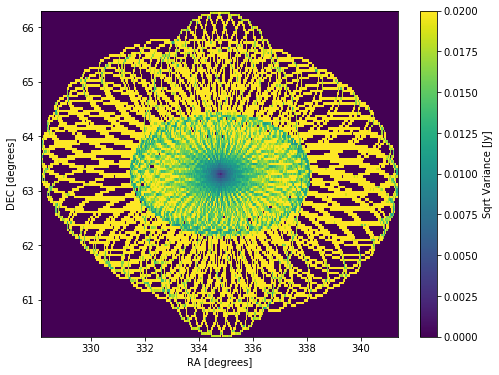

In [13]:
calibrated, gain0, gain1 = get_maps('A', 2)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


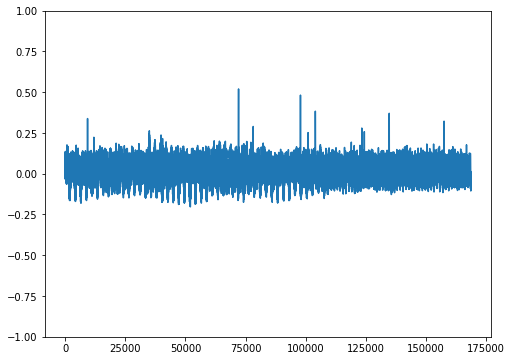

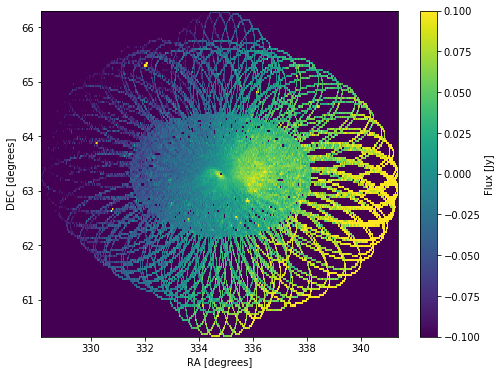

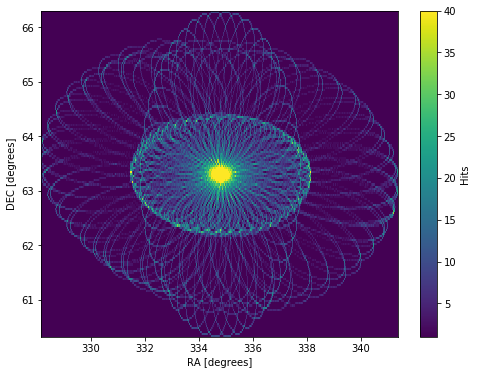

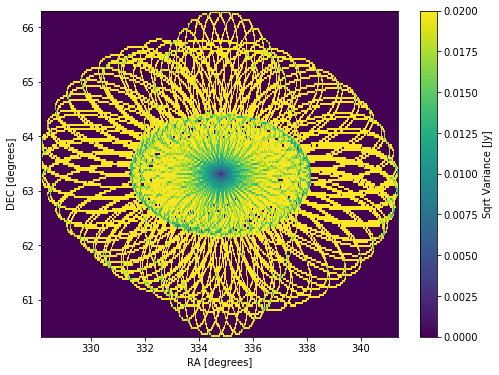

In [14]:
calibrated, gain0, gain1 = get_maps('B', 2)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


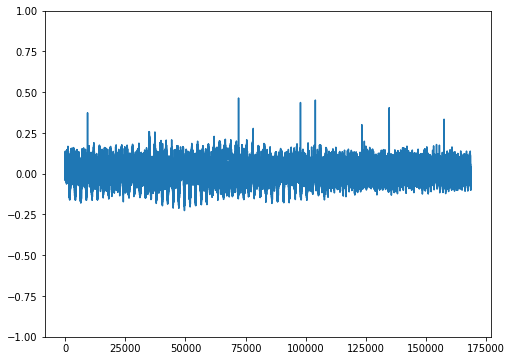

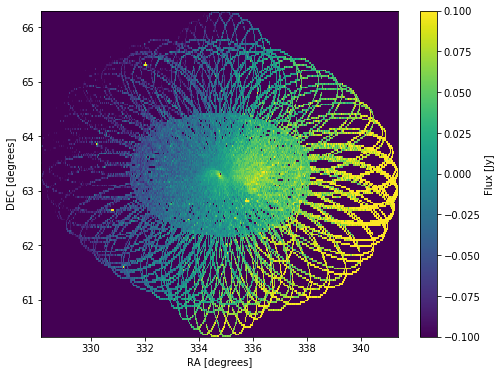

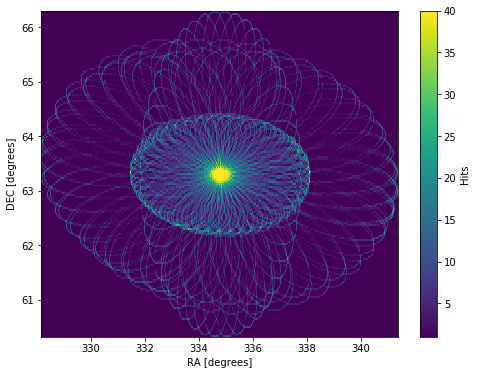

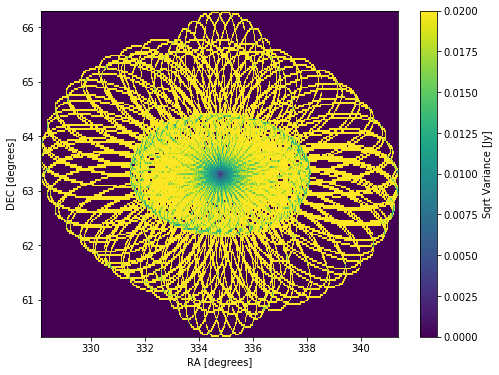

In [15]:
calibrated, gain0, gain1 = get_maps('C', 2)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


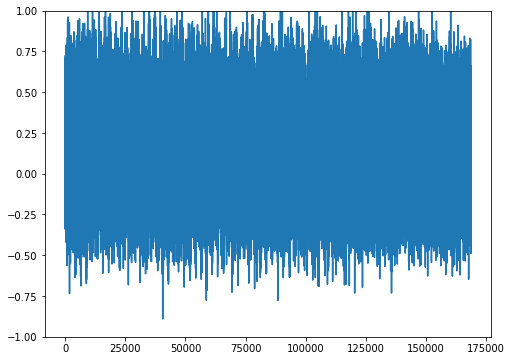

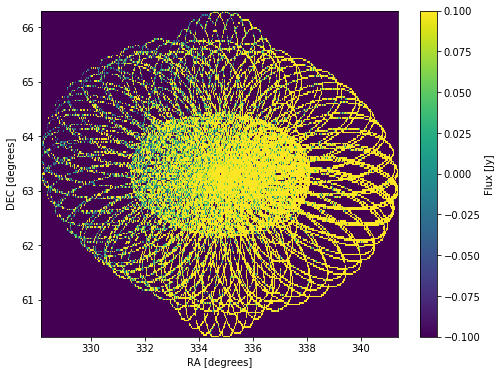

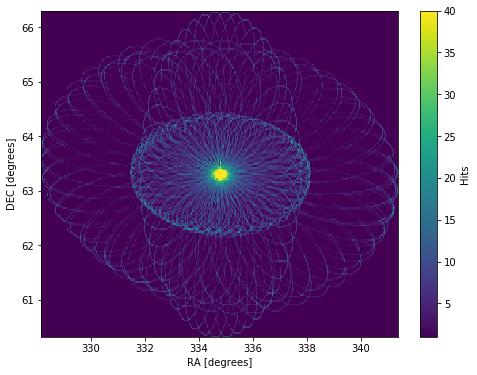

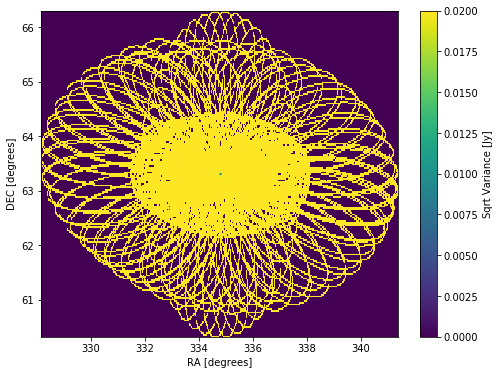

In [16]:
calibrated, gain0, gain1 = get_maps('D', 2)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


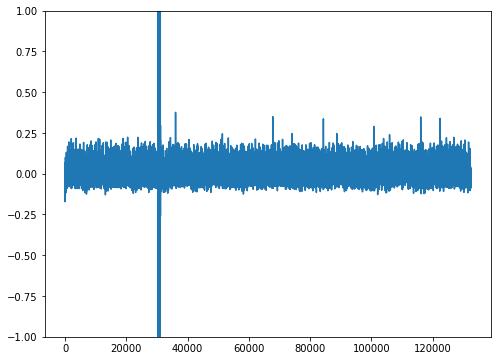

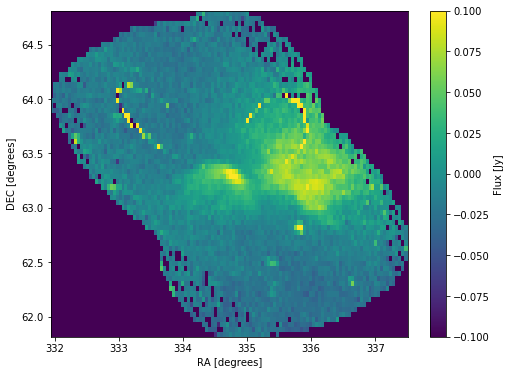

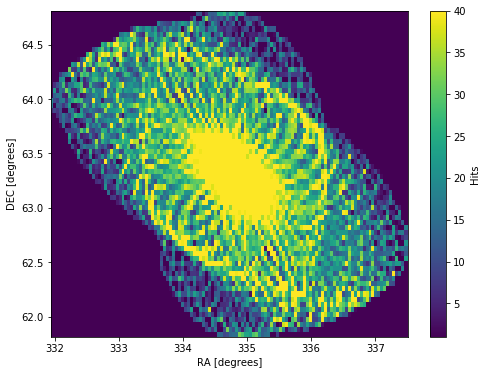

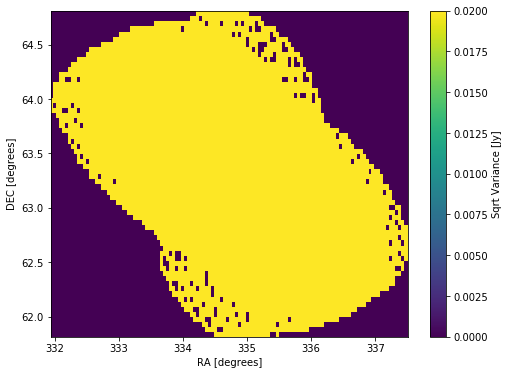

In [17]:
calibrated, gain0, gain1 = get_maps('A', 3)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


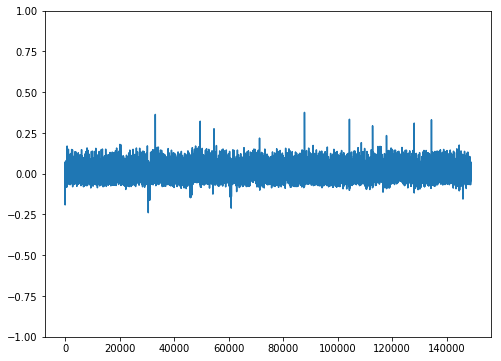

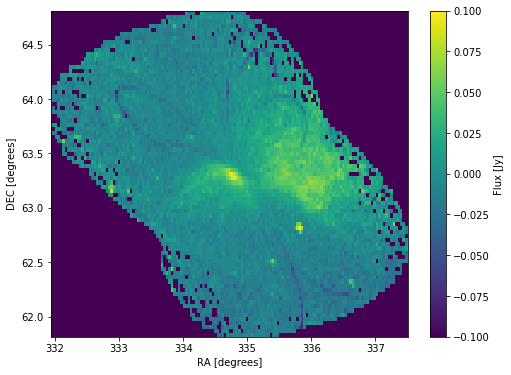

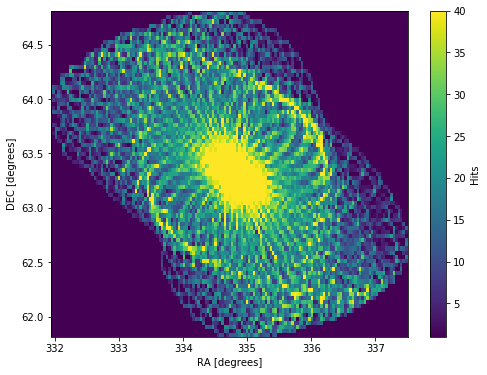

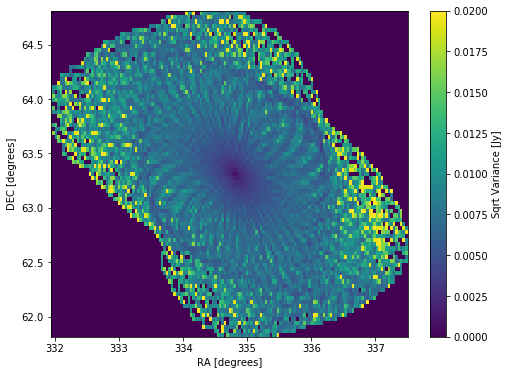

In [18]:
calibrated, gain0, gain1 = get_maps('B', 3)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


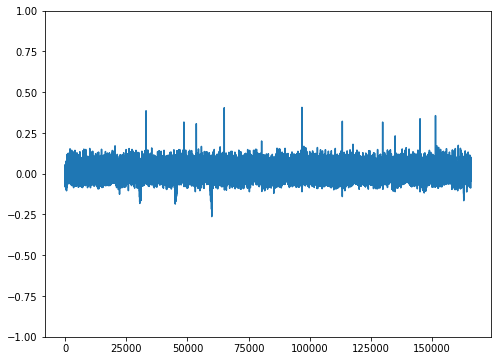

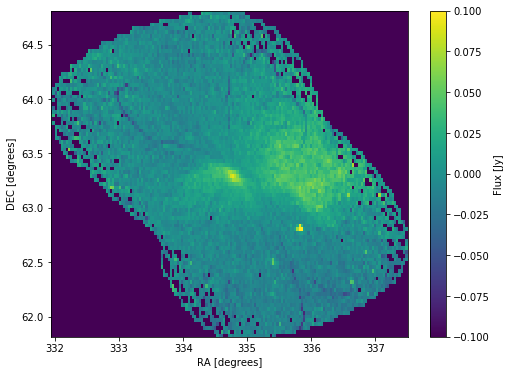

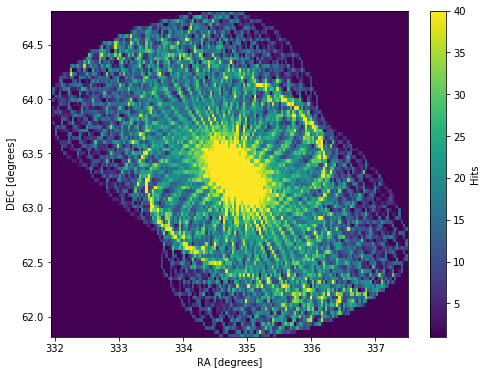

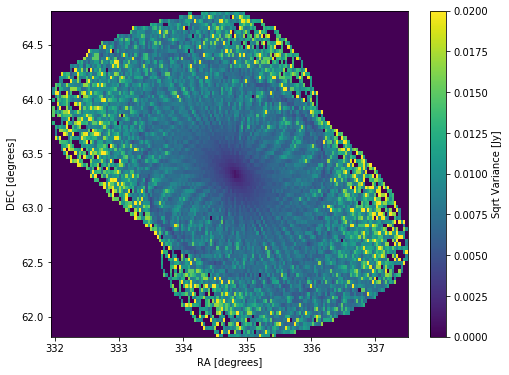

In [19]:
calibrated, gain0, gain1 = get_maps('C', 3)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide


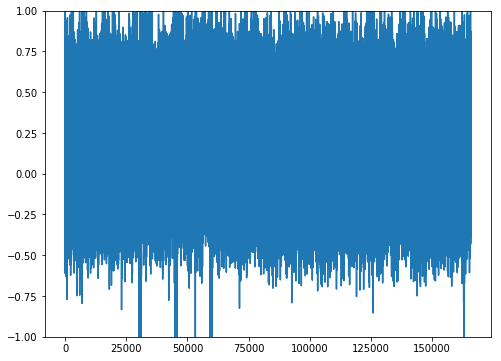

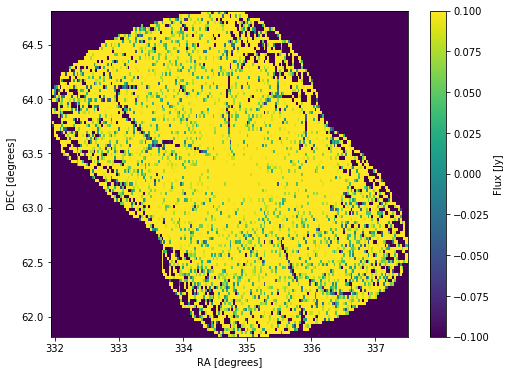

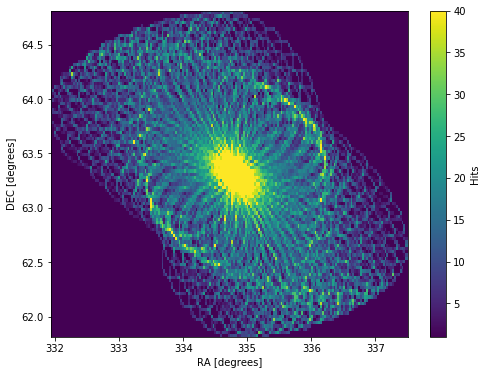

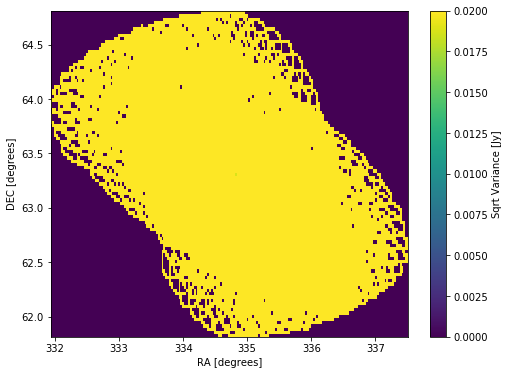

In [20]:
calibrated, gain0, gain1 = get_maps('D', 3)

In [49]:
calibrated, meansub, ras, decs, azs, els, gain0, gain1 = get_data('C', 3)

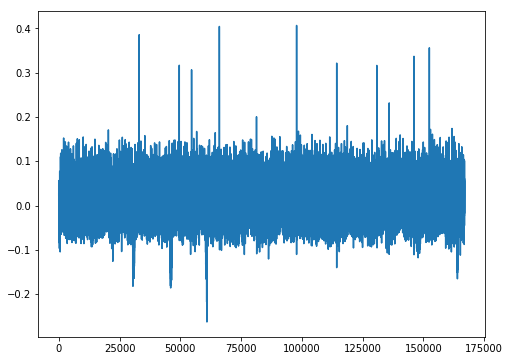

In [50]:
plot(calibrated)

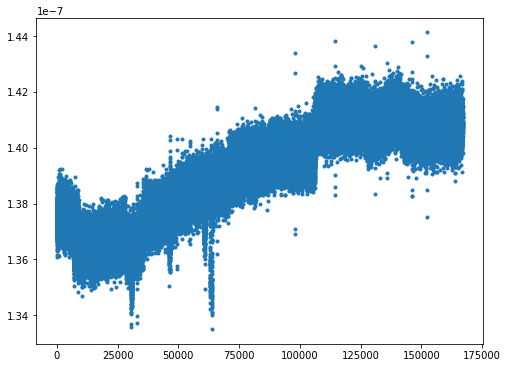

In [51]:
plot(gain1, '.')

(0, 1024)

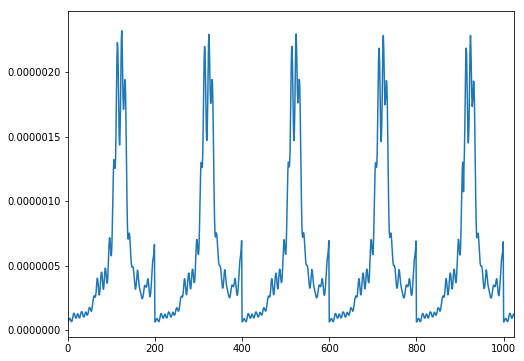

In [22]:
plot(gain0)
xlim(0, 1024)

In [42]:
# bank A
# for session 3 cut off 35000 to 50000
# for session 3 cut off 1625000 to end
# bank B
# for session 3 cut off 62000 to 72000
# for session 3 cut off 120000 to 128000
# bank C and D
# for session 3 cut off 38000 to 39000

(25000, 80000)

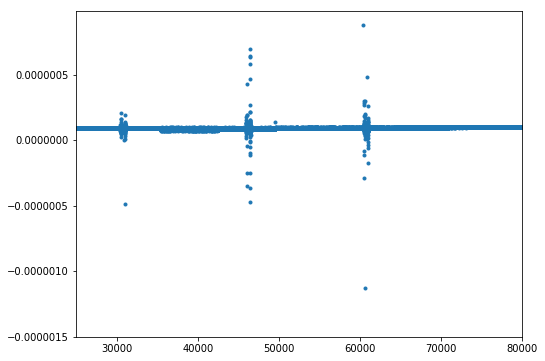

In [43]:
plot(gain1, '.')
xlim(25000, 80000)

(162000, 170000)

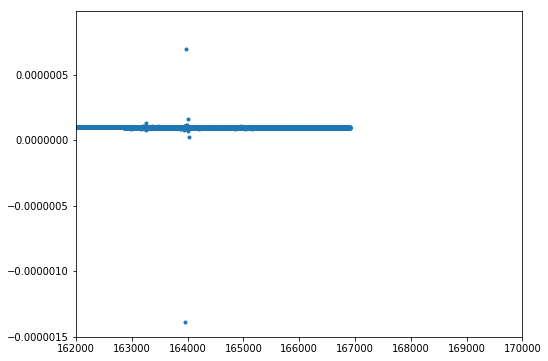

In [44]:
plot(gain1, '.')
xlim(162000, 170000)